In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import norm
from keras.datasets import mnist
import time

Diabetes dataset

In [ ]:
'''
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df = diabetes_df.dropna()
diabetes_di = {1: 1, 0: -1}
diabetes_df = diabetes_df.replace({"Outcome": diabetes_di})
X = diabetes_df.iloc[:, 0:8]
Y = diabetes_df.iloc[:, 8]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy().reshape(X_train.shape[0],1)
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy().reshape(X_test.shape[0],1)
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
'''

'\ndiabetes_df = pd.read_csv(\'diabetes.csv\')\ndiabetes_df = diabetes_df.dropna()\ndiabetes_di = {1: 1, 0: -1}\ndiabetes_df = diabetes_df.replace({"Outcome": diabetes_di})\nX = diabetes_df.iloc[:, 0:8]\nY = diabetes_df.iloc[:, 8]\nX_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)\nX_train = X_train.to_numpy()\nY_train = Y_train.to_numpy().reshape(X_train.shape[0],1)\nX_test = X_test.to_numpy()\nY_test = Y_test.to_numpy().reshape(X_test.shape[0],1)\nscaler = MinMaxScaler()\nscaler = scaler.fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\n'

Heart disease dataset

In [ ]:

heart_df = pd.read_csv('framingham.csv')
heart_df = heart_df.dropna()
heart_di = {1: 1, 0: -1}
heart_df = heart_df.replace({"TenYearCHD": heart_di})
X = heart_df.iloc[:, 0:15]
Y = heart_df.iloc[:, 15]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy().reshape(X_train.shape[0],1)
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy().reshape(X_test.shape[0],1)
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Activation function of logistic regression
\begin{align}
F(W) = \frac{1}{1+\exp(-W^{T}x_{i})}
\end{align}

In [ ]:
def logreg_function(X,W):
  return 1/(1 + math.exp(-np.dot(W,X)))

Logistic Regression loss function to optimize

\begin{align}
F(W) = \frac{1}{m} \sum_{i=1}^m\ln(1+\exp(-y_{i} \cdot W^{T}x_{i}))
\end{align}
(*1 ≤ i ≤ m m = number of examples*) \\
with constraint:
\begin{align}
\Vert W \Vert_{1} \le r
\end{align}

(*with r = 1 this is equivalent to solving the l1-ball problem which is what we have done*)


In [ ]:
def logreg_loss_function(W,A,Y):

  return 1/A.shape[0] * np.sum([math.log(1 + math.exp(-Y[x]*np.dot(W,A[x,:]))) for x in range(A.shape[0])])


The full gradient of the Logistic Regression function

\begin{align}
\frac{∂ F(W)}{∂ W_{j}} &= \frac{1}{m} \sum_{i=1}^m \frac{-y^{i} \cdot x^{j}_{i}}{1+\exp(y_{i} \cdot W^{T}x_{i})}
\end{align}
(*1 ≤ j ≤ n n = number of variables*) \\

In [ ]:
def get_full_gradient(W,A,Y):

  gradient = np.zeros(A.shape[1])

  for k in range(A.shape[1]):

    gradient[k] = 1/A.shape[0] * np.sum([-Y[x]*A[x,k]/( 1 + math.exp(Y[x]*np.dot(W,A[x,:]))) for x in range(A.shape[0])])

  return gradient.flatten()

A random stochastic gradient of the Logistic Regression function

In [ ]:
def get_stochastic_gradient(W,A,Y,ik):

  gradient = np.zeros(A.shape[1])

  for k in range(A.shape[1]):

    gradient[k] = -Y[ik]*A[ik,k]/( 1 + math.exp(Y[ik]*np.dot(W,A[ik,:])))

  return gradient.flatten()

FW problem solution standard case

In [ ]:
def get_FWP_solution_Standard(gradient):

  index_max = np.argmax(np.absolute(gradient))

  vt = np.sign(-gradient[index_max]) * np.eye(len(gradient))[:,index_max]

  return vt

FW problem solution SCG

In [ ]:
def get_FWP_solution_SCG(gradient,pt,dtprev):

  dt = (1-pt)*dtprev + pt*gradient

  index_max = np.argmax(np.absolute(dt))

  vt = np.sign(-dt[index_max]) * np.eye(len(gradient))[:,index_max]

  return vt,dt

FW problem solution 1-SFW

In [ ]:
def get_FWP_solution_1_SFW(gradient,pt,dtprev,grad_diff):

  dt = (1-pt)*(dtprev+grad_diff) + pt*gradient

  index_max = np.argmax(np.absolute(dt))

  vt = np.sign(-dt[index_max]) * np.eye(len(gradient))[:,index_max]

  return vt,dt

SFW algorithm

In [ ]:
def SFW(W,A,Y,iterations):

  dtprev = np.zeros(len(W))
  vt = np.zeros(len(W))
  trace_fx = []
  trace_time = []
  start = time.time()


  for iteration in range(1,iterations):

    # Tracing Loss function
    trace_fx.append(logreg_loss_function(W,A,Y))
    trace_time.append(time.time()-start)

    # Parameters
    gamma = 2 / (iteration+1)

    pt = 4/ pow((iteration+8),2/3)
    '''
    mk = np.max((iteration**2,A.shape[0]))

    avg_gradient = np.zeros(len(W))

    for i in range(mk):

      avg_gradient += get_stochastic_gradient(W,A,Y,np.random.randint(0,A.shape[0]))

    avg_gradient = avg_gradient/mk

    # FW problem solution 1
    vt = np.array(get_FWP_solution_Standard(avg_gradient))
    '''
    # FW problem solution 2
    vt = np.array(get_FWP_solution_Standard(get_stochastic_gradient(W,A,Y,np.random.randint(0,X_train.shape[0]))))

    # Weight update
    W = (1-gamma)*W + gamma*vt


  return W, trace_fx,trace_time

SCG algorithm

In [ ]:
def Frank_Wolfe_SCG(W,A,Y,iterations):

  dtprev = np.zeros(len(W))
  vt = np.zeros(len(W))
  trace_fx = []
  trace_time = []
  start = time.time()
  W_history = []
  estimate = []

  for iteration in range(1,iterations):

    # Tracing Loss function
    trace_fx.append(logreg_loss_function(W,A,Y))
    trace_time.append(time.time()-start)
    W_history.append(W)
    estimate.append(dtprev)

    # Parameters
    gamma = 2 / (8 + iteration)

    pt = 4/ pow((iteration+8),2/3)

    # FW problem solution
    vt, dtprev = np.array(get_FWP_solution_SCG(get_stochastic_gradient(W,A,Y,np.random.randint(0,A.shape[0])),pt,dtprev))

    # Weights update
    W = (1-gamma)*W + gamma*vt


  return W, trace_fx,trace_time,W_history,estimate

1-SFW algorithm

In [ ]:
def Frank_Wolfe_1_SFW(W,A,Y,iterations):

  dtprev = np.zeros(len(W))
  vt = np.zeros(len(W))
  Wprev = np.zeros(len(W))
  grad_diff = np.zeros(len(W))
  trace_fx = []
  trace_time = []
  start = time.time()

  for iteration in range(1,iterations):

    # Tracing Loss function
    trace_fx.append(logreg_loss_function(W,A,Y))
    trace_time.append(time.time()-start)

    # Parameters
    gamma = pow(iteration,-1)

    if iteration == 1:

      vt, dtprev = np.array(get_FWP_solution_1_SFW(get_stochastic_gradient(W,A,Y,np.random.randint(0,A.shape[0])),1,dtprev,grad_diff))

    else:

      pt = pow((iteration-1),-1)

      ik = np.random.randint(0,A.shape[0])

      current_stoch_grad = get_stochastic_gradient(W,A,Y,ik)

      # Difference between stoch gradient at previous and current iteration for the same datapoint
      grad_diff = current_stoch_grad-get_stochastic_gradient(Wprev,A,Y,ik)

      # FW problem solution
      vt, dtprev = np.array(get_FWP_solution_1_SFW(current_stoch_grad,pt,dtprev,grad_diff))

    # Weights Update
    Wprev = W
    W = (1-gamma)*W + gamma*vt

  return W, trace_fx,trace_time

SFW execution

In [ ]:
initial_point = np.zeros(X_train.shape[1])
initial_point[0] = 1
iterations = 500
print("Starting loss = " + str(logreg_loss_function(initial_point,X_train,Y_train)))
xk_star,trace_fx,trace_time_x = SFW(initial_point,X_train,Y_train,iterations)
print("Final loss = " + str(logreg_loss_function(xk_star,X_train,Y_train)))

support = [logreg_function(X_test[i,:],xk_star) for i in range(len(Y_test))]
prediction = [1 if i > 0.5 else -1 for i in support]
support = list(prediction == Y_test.flatten())
result = support.count(True)/len(support)
print("accuracy = " + str(result))
print("number of right predictions = " + str(support.count(True)) + " out of " + str(len(support)))

Starting loss = 0.8883174759541577
Final loss = 0.6125826344922497
accuracy = 0.8469945355191257
number of right predictions = 310 out of 366


SCG execution

In [ ]:
initial_point = np.zeros(X_train.shape[1])
initial_point[0] = 1
iterations = 500
print("Starting loss = " + str(logreg_loss_function(initial_point,X_train,Y_train)))
xk_star,trace_fy,trace_time_y,W_history,estimate = Frank_Wolfe_SCG(initial_point,X_train,Y_train,iterations)
print("Final loss = " + str(logreg_loss_function(xk_star,X_train,Y_train)))

support = [logreg_function(X_test[i,:],xk_star) for i in range(len(Y_test))]
prediction = [1 if i > 0.5 else -1 for i in support]
support = list(prediction == Y_test.flatten())
result = support.count(True)/len(support)
print("accuracy = " + str(result))
print("number of right predictions = " + str(support.count(True)) + " out of " + str(len(support)))

Starting loss = 0.8883174759541577
Final loss = 0.5850236466468374
accuracy = 0.8469945355191257
number of right predictions = 310 out of 366


1-SFW execution

In [ ]:
initial_point = np.zeros(X_train.shape[1])
initial_point[0] = 1
iterations = 500
print("Starting loss = " + str(logreg_loss_function(initial_point,X_train,Y_train)))
xk_star,trace_fz,trace_time_z = Frank_Wolfe_1_SFW(initial_point,X_train,Y_train,iterations)
print("Final loss = " + str(logreg_loss_function(xk_star,X_train,Y_train)))


support = [logreg_function(X_test[i,:],xk_star) for i in range(len(Y_test))]
prediction = [1 if i > 0.5 else -1 for i in support]
support = list(prediction == Y_test.flatten())
result = support.count(True)/len(support)
print("accuracy = " + str(result))
print("number of right predictions = " + str(support.count(True)) + " out of " + str(len(support)))

Starting loss = 0.8883174759541577
Final loss = 0.5770388805821802
accuracy = 0.8469945355191257
number of right predictions = 310 out of 366


Comparison of SFW, SCG and 1-SFW

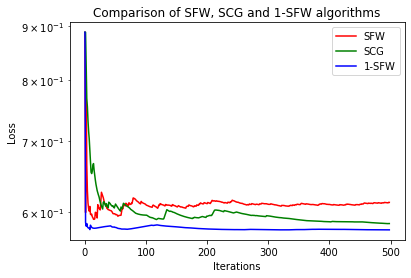

In [ ]:
plt.yscale("log")
plt.plot(trace_fx,color='r', label='SFW')
plt.plot(trace_fy,color='g', label='SCG')
plt.plot(trace_fz,color='b', label='1-SFW')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Comparison of SFW, SCG and 1-SFW algorithms")
plt.legend()
plt.show()

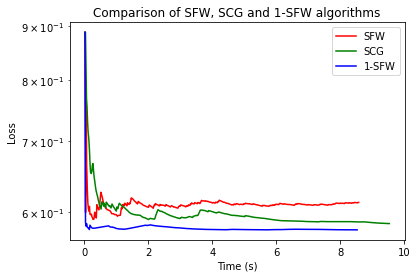

In [ ]:
plt.yscale("log")
plt.plot(trace_time_x,trace_fx,color='r', label='SFW')
plt.plot(trace_time_y,trace_fy,color='g', label='SCG')
plt.plot(trace_time_z,trace_fz,color='b', label='1-SFW')
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("Comparison of SFW, SCG and 1-SFW algorithms")
plt.legend()
plt.show()

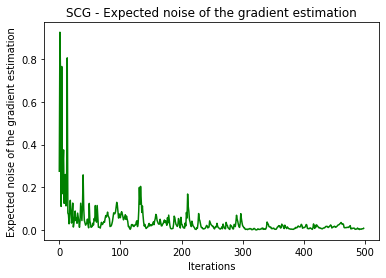

In [ ]:
full_gradient = [get_full_gradient(W_history[i],X_train, Y_train) for i in range(len(W_history))]
diff_fy = [estimate[i]-full_gradient[i] for i in range(len(W_history))]
diff_fy_norm = [np.linalg.norm(diff_fy[i],2) for i in range(len(diff_fy))]
diff_fy_norm = [pow(diff_fy_norm[i],2) for i in range(len(diff_fy_norm))]
plt.plot(diff_fy_norm,color='g')
plt.xlabel("Iterations")
plt.ylabel("Expected noise of the gradient estimation")
plt.title("SCG - Expected noise of the gradient estimation")
plt.show()

SVRF algorithm

In [ ]:
def Frank_Wolfe_SVRF(StartX,A,Y,iterations):

  # X0 = snapshot, W point at current iteration
  trace_fx = []
  trace_time = []
  start_time = time.time()
  W = get_FWP_solution_Standard(get_full_gradient(StartX,A,Y))
  for iteration in range(1,iterations):

    # Take snapshot
    X0 = W
    # Compute snapshot gradient
    gradientX0 = get_full_gradient(X0,A,Y)

    Nt = pow(2,iteration+3)-2

    for k in range(1,Nt):

      # Tracing Loss function
      trace_fx.append(logreg_loss_function(W,A,Y))
      trace_time.append(time.time()-start_time)

      # Parameters

      mk = 96*(k+1)
      gammak = 2 / (k+1)

      # Avg gradient
      gradient_counter = np.zeros(len(W))

      for i in range(mk):


        ik = np.random.randint(0,X_train.shape[0])
        gradient_counter += get_stochastic_gradient(W,A,Y,ik)-(get_stochastic_gradient(X0,A,Y,ik)-gradientX0)


      avg_gradient = gradient_counter/mk

      # FW problem solution
      vk = get_FWP_solution_Standard(avg_gradient)

      # Weights update
      W = (1-gammak)*W + gammak*(vk)

  return W,trace_fx,trace_time

SVRF execution

Starting loss = 0.8883174759541577
Final loss = 0.575024924161649
accuracy = 0.8469945355191257
number of right predictions = 310 out of 366


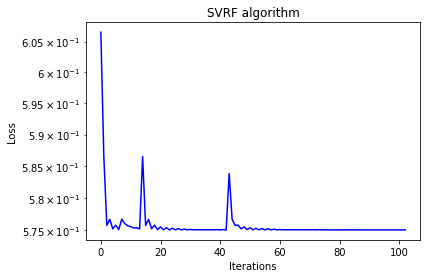

In [ ]:
initial_point = np.zeros(X_train.shape[1])
initial_point[0] = 1
iterations = 4
print("Starting loss = " + str(logreg_loss_function(initial_point,X_train,Y_train)))
xk_star,trace_fx,trace_time = Frank_Wolfe_SVRF(initial_point,X_train,Y_train,iterations)
print("Final loss = " + str(logreg_loss_function(xk_star,X_train,Y_train)))

support = [logreg_function(X_test[i,:],xk_star) for i in range(len(Y_test))]
prediction = [1 if i > 0.5 else -1 for i in support]
support = list(prediction == Y_test.flatten())
result = support.count(True)/len(support)
print("accuracy = " + str(result))
print("number of right predictions = " + str(support.count(True)) + " out of " + str(len(support)))
plt.yscale("log")
plt.plot(trace_fx,color='b', label='SVRF')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SVRF algorithm")
plt.show()

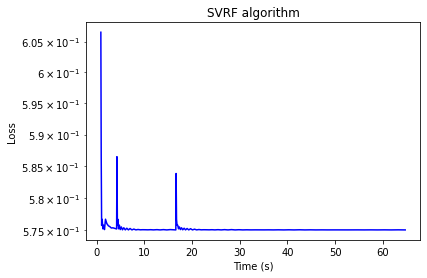

In [ ]:
plt.yscale("log")
plt.plot(trace_time,trace_fx,color='b')
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("SVRF algorithm")
plt.show()